Scope:

This branch should implement torch functionality in expsolve. 

Once investigations are done, the derivative part needs to go in fourier and splittings, for e.g., to make torch compatible derivatives, and this file should be deleted. 

Torch compatible applications should be in their own specific branches and not included here. 

# Hamiltonian Identification

In [1]:
import numpy as np
import matplotlib.pylab as plt

import expsolve as es
import expsolve.splittings.classical as split
import expsolve.fourier as ex

import torch
from torch import exp, sin, abs, real, imag, pi, diag
from torch.linalg import matrix_exp
import torch.nn as nn

from IPython import display
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Check if GPU is available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True Potential

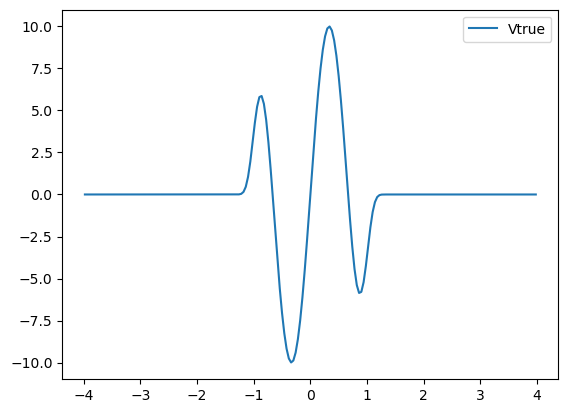

In [2]:
n = 200
L = 4
xr = [-L, L]
x = ex.grid1d(n, xr)

Vtrue = 10.*exp(-x**8/1)*sin(1.5*pi*x)

#plt.xlim(-5,5)
# plt.ylim(-100,200)

plt.plot(x, Vtrue)

plt.legend(['Vtrue'])
plt.show()

Solvers

In [3]:
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda V: lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
blanesmoanstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, blanesmoanalpha, blanesmoanbeta)

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)
strangstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, strangalpha, strangbeta)


solver = lambda V, u, T, N: es.evolve(u, es.timegrid(T, N), strangstep(V) )[0]

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


Polynomial Ansatz

Dataset

In [4]:
def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))
    u = ex.normalize(u, xr)
    return u

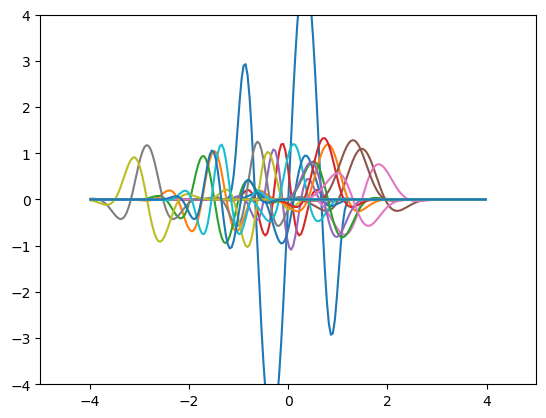

In [11]:
plt.xlim(-5,5)
plt.ylim(-4,4)

plt.plot(x, Vtrue/2)

for i in range(10):
    u0 = ugen(sx0=1.0, svar=0.3, sw0=1.5)
    plt.plot(x, real(u0))
    plt.plot(x, imag(u0))

plt.show()

Maybe the quartic paramterization is very difficult to learn

In [14]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 20),   # Fully connected layer 1 with 1 input and 32 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 1)    # Fully connected layer 3 with 16 input neurons and 1 output neuron
        )
        self.model = self.model.double()    # double precision

    def forward(self, x):
        return self.model(x)
    


In [15]:
X = torch.tensor(x.detach().numpy(), dtype=torch.float64).unsqueeze(1)

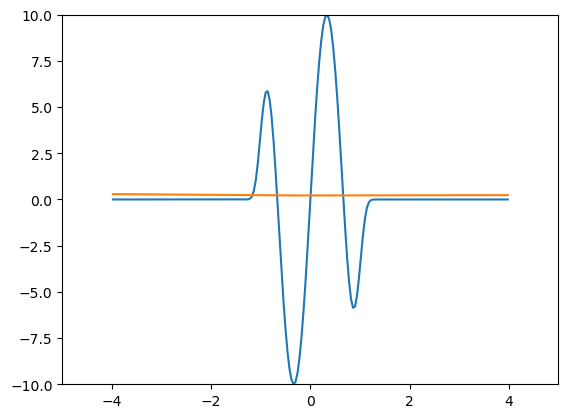

In [18]:
plt.plot(x, Vtrue)
plt.plot(x, model(X).detach().numpy())
plt.xlim(-5,5)
plt.ylim(-10,10)

plt.show()

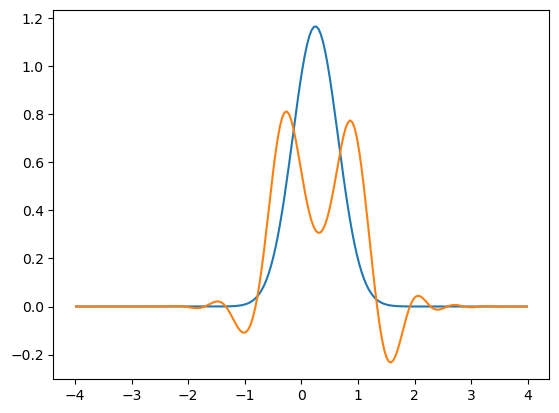

In [25]:
u = ugen(sx0=1.5, svar=0.3, sw0=1.5)
plt.plot(x, real(u))
plt.plot(x, real(solver(Vtrue, u, 0.1, 20)))

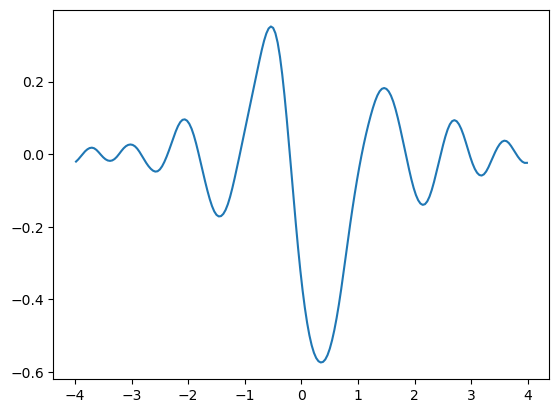

In [32]:
plt.plot(x, real(solver(Vtrue, u, 0.2, 20)-solver(0*Vtrue, u, 0.2, 20)))    # what happens when we get V incorrect
plt.show()

In [39]:
lossfn = lambda V, u, T, N: torch.norm(solver(V, u, T, N) - solver(Vtrue, u, T, N) )**2

#nrm = lambda v: real( sum(v.conj() * v) )
#lossfn = lambda V, u: ex.l2norm(solver(V, u) - solver(Vtrue, u) )**2

def loss_batch(V, nbatch, T, N):
    dx = x[1]-x[0]

    loss = torch.tensor(0., dtype=torch.float64)

    for i in range(nbatch):
        u = ugen(sx0=1, svar=0.3, sw0=1.5)
        L = lossfn(V, u, T, N)
        loss += L
    
    loss = dx * loss/nbatch

    return loss

In [40]:
%matplotlib inline

# Create an instance of the SimpleNN model
model = SimpleNN()
#model.to(device)

# not sure this is working
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, dtype=torch.double)
num_steps = 1000

trerror = []

for step in range(num_steps):
    # Compute the loss
    V = model(X)
    V.requires_grad_()
    V=V.reshape([n])
    loss = loss_batch(V, nbatch=10, T=0.1, N=20)

    trerror.append(loss.detach().numpy())
    
    print(f'At step {step}, loss is {loss}')

    # Zero the gradients to prevent accumulation
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    if np.mod(step, 100)==0:
        plt.semilogy(trerror)
        display.display(plt.gcf())
        display.clear_output(wait=True)


    # Update parameters using the gradients
    optimizer.step()


print(f'At step {step}, loss is {loss}')

At step 0, loss is 0.07465535710502719
At step 1, loss is 0.16984650121392508
At step 2, loss is 0.11210962248651216
At step 3, loss is 0.08576935360151165
At step 4, loss is 0.13720830071723727
At step 5, loss is 0.12705615065941211
At step 6, loss is 0.1214946874160256
At step 7, loss is 0.13655897318381283
At step 8, loss is 0.1458488384792986
At step 9, loss is 0.1234561360230566
At step 10, loss is 0.052098440308796214
At step 11, loss is 0.06492307686772576
At step 12, loss is 0.12238054335425111
At step 13, loss is 0.10557544626811281
At step 14, loss is 0.08367153565888143
At step 15, loss is 0.06983314499749058
At step 16, loss is 0.110383676086758
At step 17, loss is 0.08139289701595886
At step 18, loss is 0.0850675048286015
At step 19, loss is 0.12672682436044527
At step 20, loss is 0.11656211851840526
At step 21, loss is 0.11226497045727127
At step 22, loss is 0.12011590115956321
At step 23, loss is 0.14900233136517846
At step 24, loss is 0.0654543463821225
At step 25, loss

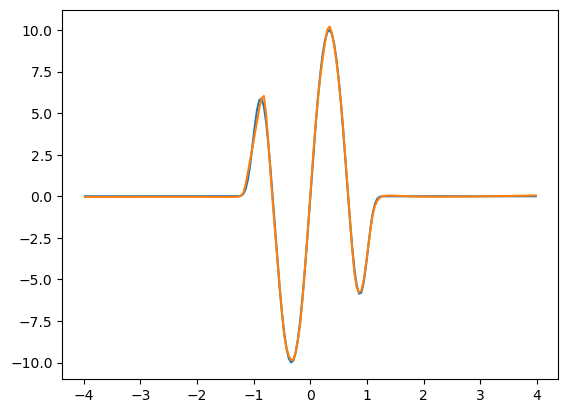

In [41]:
plt.plot(x, Vtrue)
plt.plot(x, V.detach().numpy())